In [1]:
from PyInventor import *
import numpy as np
from numpy import pi, cos, sin, sqrt, log
import math
import glob
import time
import copy
import csv

#Import plotting libraries for later
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import path
import matplotlib.tri as tri

import pandas as pd

import pyEPR
from pyEPR import ansys as HFSS

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity

#import yaml for loading qubit config, you may need to pip install these
import ruyaml
import dpath.util

import os

from _field_pts_export_utils import *
from _rect_cav_utils import *

In [5]:
"""
Single mode pan-pipe Cavity creation using inventor
"""

units='imperial'

#put in target frequency
target_freq=6.375E9 #Hz<--This is what will set the estimated cavity frequency and then try and optimize the size

#general cavity parameters
hole_spacing=.2375
hole_dia=.25
H_stock=1.75
evan_length=.25
stock_origin=(0,0)


#calculate cavity height allowed by stock
H_cav=H_stock-2*evan_length

#calculate what you want the length of t he cavity to be for  the proper fundamental frequency
L_cav=get_c_dim(target_freq, H_cav, hole_dia, units)

#calculate stock length for the given cavity length needed, rounds length to nearest designated fraction
L_stock=round_dim(L_cav, .25)
W_stock=round_dim(hole_dia, .125)

#start inventor and close all inventor objects
com_obj().close_all_parts()

#set it to overwrite file every time the part is instantiated (REMEMBER TO PUT SAVE AT THE BOTTOM!)
overwrite=True

#filename
fname='Single_Mode_Rect.ipt'

#path
#path='S:\\Andrew Oriani\\CQED 3D Resonators\\Multimode Manipulate Cavity\\3D MM V3'

#for demo set the path to path='' to save in current working directory
cav_path=''

#setup part 
part=iPart(path=cav_path, prefix=fname, units=units, overwrite=overwrite)

#set view as shaded with edges
part.set_visual_style(shaded=True, edges=True, hidden_edges=True)

#set starting workplane
cav_wp=part.add_workplane(plane='xy', offset=-H_cav/2)

#cav workplane
cav_sketch=part.new_sketch(cav_wp)

#create stock wp and sketch
stock_wp=part.add_workplane(plane='xy', offset=-H_stock/2)

#attach a sketch to the workplane
stock_sketch=part.new_sketch(stock_wp)

#create cavity outline
s=structure(part=part, sketch=cav_sketch, start=(-(L_cav-hole_dia)/2, hole_dia/2))

#create cavity outline
s=structure(part=part, sketch=cav_sketch, start=(-(L_cav-hole_dia)/2, -hole_dia/2))
s.add_line(L_cav-hole_dia, 0)
s.add_line_arc(start_angle=180, stop_angle=90, radius=hole_dia/2, flip_dir=True, mirror=False, rotation=0)
s.add_line(-(L_cav-hole_dia), 0)
s.add_line_arc(start_angle=180, stop_angle=90, radius=hole_dia/2, flip_dir=True, mirror=False, rotation=180)
cav_profile=s.draw_path(close_path=True)

#create stock outline
stock_profile=part.two_point_centered_rect(stock_sketch, center=(0,0), corner=(L_stock/2, W_stock/2))

#do the extrusions to make the cavity
part.extrude(sketch=stock_sketch, thickness=H_stock, obj_collection=stock_profile, direction='positive')

part.extrude(sketch=cav_sketch, thickness=H_cav, obj_collection=cav_profile, direction="positive", operation='cut')


# #Save document 
part.save()

# save copy as stp file for export to HFSS
cav_path=part.save_copy_as(copy_name='rect_cavity_vol.stp' )



File successfully copied as: C:\_Lib\python\Automated-RF-Design\3D Cavity Demonstrations\rect_cavity_vol.stp


In [6]:
project_name='Rect_Cavity'
design_name='Rect_Cav_EM'
overwrite=True

# cav_path='s:\\Andrew Oriani\\CQED 3D Resonators\\Elliptical Cavities\\00017_bezier_cav.stp'

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\'+project_name+'.aedt'


HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)

EM_design.make_active()
model=HFSS.HfssModeler(EM_design)
model.import_3D_obj(cav_path)

objs=model.get_object_names()
print(objs)
model.assign_material(objs=objs, material='vacuum', solve_inside=True)

EM_setup=EM_design.create_em_setup(name='Test_EM', 
                                   min_freq_ghz=1, 
                                   n_modes=2, 
                                   max_delta_f=0.1, 
                                   min_converged=3, 
                                   converge_on_real=True)

# time.sleep(5)

EM_setup.analyze()
solns=EM_setup.get_solutions()

project.save()

calc=HFSS.HfssFieldsCalc(EM_setup)

calc.clear_named_expressions()

Se_calc_path=HFSS_path+"\\E_energy_S_to_V.clc"
Sm_calc_path=HFSS_path+"\\H_energy_S_to_V.clc"

Se_name=calc.load_named_expression(Se_calc_path)
Sm_name=calc.load_named_expression(Sm_calc_path)

eigen_real=solns.eigenmodes()[0]
eigen_imag=solns.eigenmodes()[1]

print('Eigenmodes:')
print('_____________________________')
for n, em_real in enumerate(eigen_real):
    print('Mode #%i: %.3f'%(n+1, em_real))
    
print('_____________________________')

n_modes=2
Se=[]
Sm=[]
for n in range(1,n_modes+1):
    solns.set_mode(n)
    Se.append(calc.use_named_expression(Se_name).evaluate())
    Sm.append(calc.use_named_expression(Sm_name).evaluate())
    print('Se=%.3f, Sm=%.3f for mode number %i'%(Se[-1], Sm[-1], n))


solns.set_mode(1)

project.save()


['Solid1']


INFO 03:35PM [analyze]: Analyzing setup Test_EM


Eigenmodes:
_____________________________
Mode #1: 3.612
Mode #2: 3.621
_____________________________


C:\Users\cssri\Anaconda3\lib\site-packages\pyepr-0.8-py3.8.egg\pyEPR\ansys.py:3360: UserWarning: .clc file requested not in path
  warnings.warn('.clc file requested not in path')


KeyError: None

In [7]:
#make field profile plot in xz plane, but first we need points to define the boundary
c1=(L_cav/2, H_cav/2)#<--first corner 

box_pts=[c1, (-c1[0], c1[1]), (-c1[0], -c1[1]), (c1[0], -c1[1]), c1]#<--coordinates of all corners

box_pts=np.array(box_pts).T#<---some transformations to make a nice plot

#create random set of points within boundary
mesh_pts=gen_mesh_pts(box_pts,n_samples=5000, mesh_type='grid')*0.0254

#save mesh points to a pts file
mesh_file=save_mesh(mesh_pts, fname='new_mesh_file.pts', plane='xz')

#setup filenames
pts_file=os.getcwd()+'\\'+mesh_file
export_file=os.getcwd()+'\\'+'test_file.fld'

#first set to correct mode
solns.set_mode(1)

#set what field we want to generate. Uses Named Calc Objects for calculation
field=calc.Mag_E

#use export field from points function of calculator object
fields_file=calc.export_fields_from_pts(pts_file=pts_file, export_file=export_file, field_expr=field, phase=0)

w=abs(max(box_pts[0])-min(box_pts[0]))
h=abs(max(box_pts[1])-min(box_pts[1]))
w_plt=6
plt.figure(figsize=(w_plt, w_plt*(h/w)))
plt.plot(box_pts[0]*0.0254, box_pts[1]*0.0254, '-r')
plt.plot(mesh_pts[0], mesh_pts[1], '.b')

AttributeError: 'HfssFieldsCalc' object has no attribute 'export_fields_from_pts'

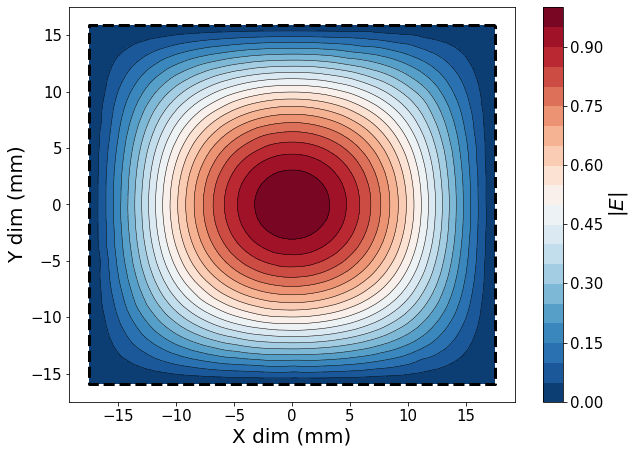

In [125]:
#compute field profile
#create interpolated mesh from fields file. The mask flag will mask out the interpolated points to avoid interpolation artifacts. A boundary must be set for a mask to be used.
#Skipping will speed up the mask generation
mm_pts=box_pts*0.0254
x,y,z=interp_mesh(field_file=fields_file, plane='xz', boundary=mm_pts, mask=True, skip=5, bound_value=0)

#set plot width and scale for roughly scale proportions
w_plt=8
fig, ax1 = plt.subplots(1, figsize=(1.25*w_plt, w_plt*(h/w)))

#for ease of plotting we will 
levels=20

ax1.contour(x*1000, (y)*1000, z, levels=levels, linewidths=0.5, colors='k', corner_mask=True)
cntr1 = ax1.contourf(x*1000, (y)*1000, z, levels=levels, cmap="RdBu_r", corner_mask=True)

cbar=fig.colorbar(cntr1, ax=ax1)

cbar.set_label('$|E|$', fontsize=20)
cbar.ax.tick_params(labelsize=15)
# ax1.plot(x, y, 'ko', ms=3)
w=abs(max(box_pts[0]))
h=abs(max(box_pts[1]))
w_plt=6
ax1.plot(mm_pts[0]*1000, mm_pts[1]*1000, '--k', linewidth=3)
ax1.set_xlabel('X dim (mm)', fontsize=20)
ax1.set_ylabel('Y dim (mm)', fontsize=20)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlim([1.1*min(mm_pts[0]*1000), 1.1*max(mm_pts[0]*1000)])
ax1.set_ylim([1.1*min(mm_pts[1])*1000, 1.1*max(mm_pts[1])*1000])
# ax1.axis('off')
fig.savefig('rect cavity mag E.png', dpi=400, bbox_inches='tight')

In [113]:
mm_pts

array([[ 0.01749547, -0.01749547, -0.01749547,  0.01749547,  0.01749547],
       [ 0.015875  ,  0.015875  , -0.015875  , -0.015875  ,  0.015875  ]])

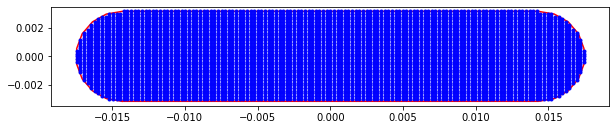

In [118]:
#now lets do the other cross section
#first set point boundary
pts=np.array(s.get_plt_pts())
pts=np.transpose(pts)

#create random set of points within boundary
mesh_pts=gen_mesh_pts(pts,n_samples=5000, mesh_type='grid')*0.0254

#save mesh points to a pts file
mesh_file=save_mesh(mesh_pts, fname='new_mesh_file_vert.pts', plane='xy')

#setup filenames
pts_file=os.getcwd()+'\\'+mesh_file
export_file=os.getcwd()+'\\'+'test_file_vert.fld'

#first set to correct mode
solns.set_mode(1)

#set what field we want to generate. Uses Named Calc Objects for calculation
field=calc.Mag_E

#use export field from points function of calculator object
fields_file=calc.export_fields_from_pts(pts_file=pts_file, export_file=export_file, field_expr=field, phase=0)

#plot sample points

w=abs(max(pts[0])-min(pts[0]))
h=abs(max(pts[1])-min(pts[1]))
w_plt=10
plt.figure(figsize=(w_plt, w_plt*(h/w)))
plt.plot(pts[0]*0.0254, pts[1]*0.0254, '-r')
plt.plot(mesh_pts[0], mesh_pts[1], '.b')

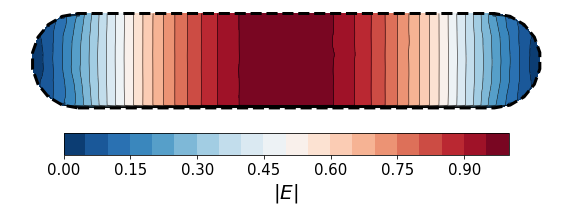

In [120]:

#create interpolated mesh from fields file. The mask flag will mask out the interpolated points to avoid interpolation artifacts. A boundary must be set for a mask to be used.
#Skipping will speed up the mask generation
mm_pts=pts*0.0254
x,y,z=interp_mesh(field_file=fields_file, boundary=mm_pts, mask=True, skip=5, plane='xy', bound_value=0)

#set plot width and scale for roughly scale proportions
w_plt=10
fig, ax1 = plt.subplots(1, figsize=(w_plt, 1.5*w_plt*(h/w)))

#for ease of plotting we will 
levels=20

ax1.contour(x*1000, (y-min(y)/2)*1000, z, levels=levels, linewidths=0.5, colors='k', corner_mask=True)
cntr1 = ax1.contourf(x*1000, (y-min(y)/2)*1000, z, levels=levels, cmap="RdBu_r", corner_mask=True)

cbar=fig.colorbar(cntr1, ax=ax1, orientation='horizontal')

cbar.set_label('$|E|$', fontsize=20)
cbar.ax.tick_params(labelsize=15)
# ax1.plot(x, y, 'ko', ms=3)
w=abs(max(pts[0])-min(pts[0]))
h=abs(max(pts[1])-min(pts[1]))
w_plt=10
ax1.plot(mm_pts[0]*1000, (mm_pts[1]-min(mm_pts[1])/2)*1000, '--k', linewidth=3)
ax1.set_xlabel('X dim (mm)', fontsize=15)
ax1.set_ylabel('Y dim (mm)', fontsize=15)
ax1.set_xlim([1.1*min(mm_pts[0]*1000), 1.1*max(mm_pts[0]*1000)])
ax1.set_ylim([1.1*min(mm_pts[1]-min(mm_pts[1])/2)*1000, 1.1*max(mm_pts[1]-min(mm_pts[1])/2)*1000])
ax1.axis('off')
plt.savefig('rect cavity mag E horizontal.png', dpi=400, bbox_inches='tight')

In [86]:
def gen_mesh_pts(pts, n_samples=1000, mesh_type='random'):
    w=abs(max(pts[0])-min(pts[0]))
    h=abs(max(pts[1])-min(pts[1]))
    tuple_pts=[(x, y) for x, y in zip(pts[0], pts[1])]
    p=path.Path(tuple_pts)

    if mesh_type=='random':
        #random uniform distribution
        np.random.seed()
        dist_unif_x=np.random.uniform(0., w, n_samples)+min(pts[0])
        dist_unif_y=np.random.uniform(0., h, n_samples)+min(pts[1])

        sample_pts=[]
        for x, y in zip(dist_unif_x, dist_unif_y):
            sample_pts.append([x,y])

    elif mesh_type=='grid':
        aspect=w/h
        if aspect>2:
            aspect=2

        n_w=int(np.round(np.sqrt(n_samples)*aspect))
        n_h=int(np.round(np.sqrt(n_samples)*1/aspect))
        x_pts=np.linspace(min(pts[0]), max(pts[0]), n_w)
        y_pts=np.linspace(min(pts[1]), max(pts[1]), n_h)
        xg, yg=np.meshgrid(x_pts, y_pts)
        sample_pts=[]
        for x, y in zip(xg.flatten(), yg.flatten()):
            sample_pts.append([x,y])
        
    
    found_pts=p.contains_points(sample_pts)
    mesh_pts=np.array([s_pts for s_pts, f_pts in zip(sample_pts, found_pts) if f_pts==True])
    return np.transpose(mesh_pts)

In [74]:
h/w

0.18197674136193454